In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import geopandas as gp
import pycountry

import sys

sys.path.insert(0, "../Notebooks/Functions")
from StatsFunctions import MyFunctions as MF

In [275]:
DF = pd.read_csv("../Data/avgIQpercountry.csv")

In [276]:
#Renamed for easier access
DF.rename(
    {
        "Average IQ": "IQ",
        "Literacy Rate": "Literacy",
        "Nobel Prices": "Nobels",
        "HDI (2021)": "HDI",
        "Mean years of schooling - 2021": "SchoolYears",
        " GNI - 2021": "GNI",
        "Population - 2023": "Population",
    },
    axis=1,
    inplace=True,
)

In [277]:
DF = DF.astype({"Population": "float64"})

In [278]:
order = DF["Country"].copy().to_list()
colours = dict(zip(DF["Continent"].unique(), sns.color_palette("Paired")))
kwargs = {"hue": "Continent", "palette": colours, "edgecolor": "black", "alpha": 0.5}
# At a very late stage made a colour pallete for continents only

In [279]:
#wanted to see if group by will be useful, but seaborn does it for me already
Continents = DF.groupby("Continent").agg(
    {"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"}
)

In [280]:
#Thought might use later
less_10 = (
    DF.query("Population < 10000000")
    .groupby("Continent")
    .agg({"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"})
    .sum()
)
over_10 = (
    DF.query("Population > 10000000")
    .groupby("Continent")
    .agg({"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"})
)

In [281]:
#Not significant
fig = px.sunburst(
    DF.query("Population > 50_000_000"),
    path=["Continent", "Country"],
    values="Population",
    width=1000,
    height=600,
    title="Countries by population",
)
fig.show()

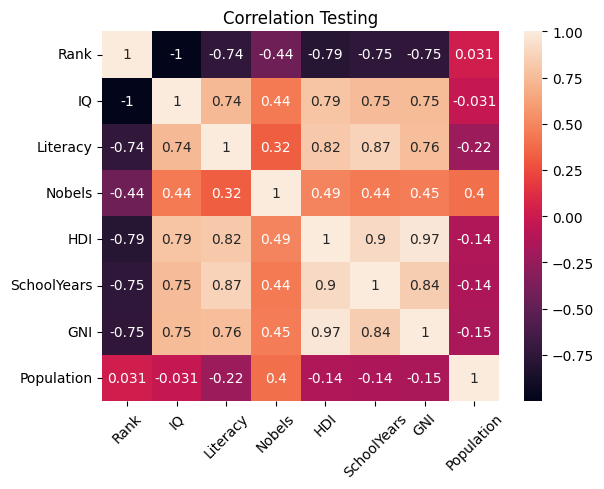

In [282]:
#decided to see pmcc between all variables quickly -> a lot of dependent variables -> need to check per continent
sns.heatmap(
    DF.select_dtypes(include=np.number).corr(method="spearman"), annot=True
)  # tk change heatmap for my example
plt.title("Correlation Testing")
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Distribution of average IQ')

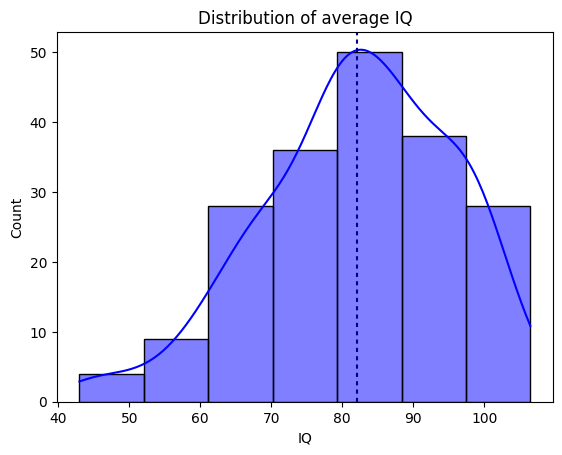

In [283]:
#decided to check average IQ and see how useful it would be
histIQ = sns.histplot(DF, x="IQ", bins=7, kde=True, color="blue")
plt.axvline(
    DF["IQ"].mean(), color="darkblue", label="mean", dashes=(2, 2)
)  # TK change mean to my function
plt.title("Distribution of average IQ")

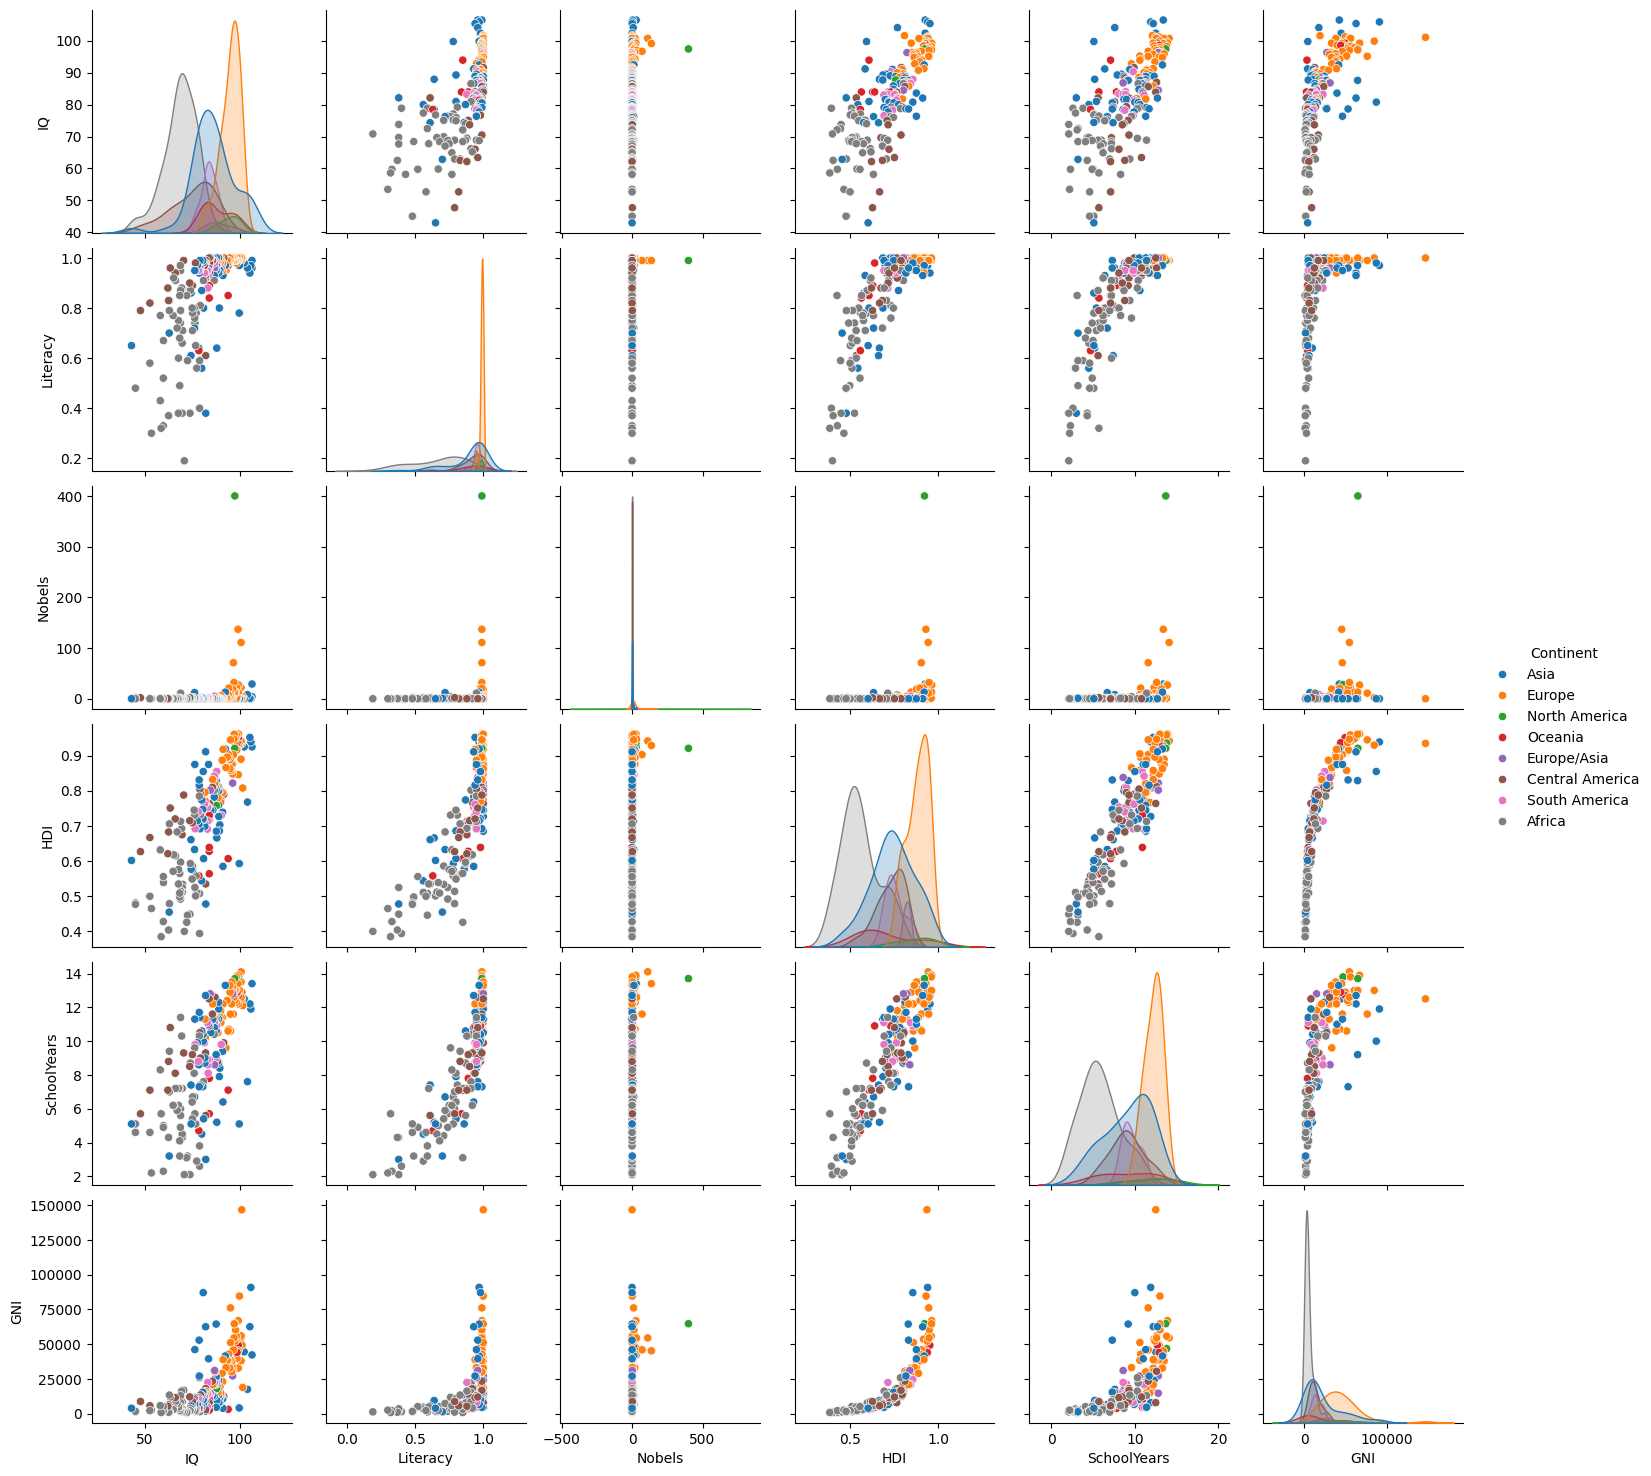

In [285]:
#Won't go in final, just to see quickly if I can use something
sns.pairplot(
    DF[
        [
            "IQ",
            "Literacy",
            "Nobels",
            "HDI",
            "Continent",
            "SchoolYears",
            "GNI",
        ]
    ],
    hue = "Continent"
    
)

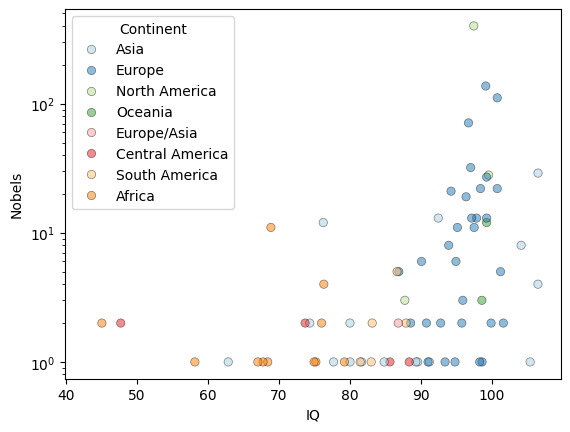

In [286]:
# Desided exprlore correlation between average IQ of a country with how many novel prises the continent won.
# Europe is on average smarter and have more entries due to more countries, but America is a clear outlier
# sns.scatterplot(data=DF, x="IQ", y="Nobels", hue="Continent", palette=colours, edgecolor = "black", alpha = 0.5)
sns.scatterplot(data=DF, x="IQ", y="Nobels", **kwargs)

plt.yscale("log")

Text(0.5, 1.0, 'Distribution of IQ for each continent')

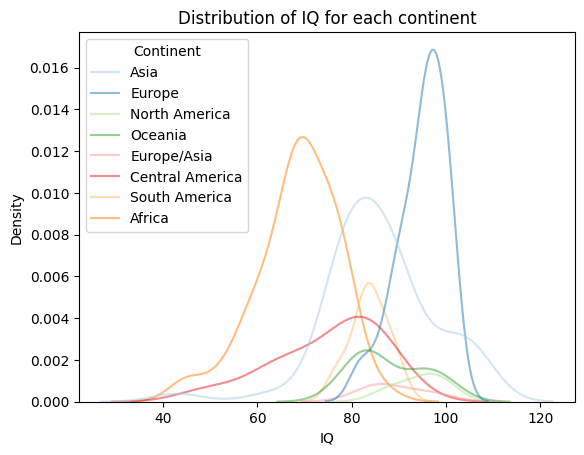

In [288]:
sns.kdeplot(data=DF, x="IQ", **{i:kwargs[i] for i in kwargs if i!='edgecolor'})
plt.title("Distribution of IQ for each continent")

Text(0.5, 1.0, 'Correlation between HDI and GNI')

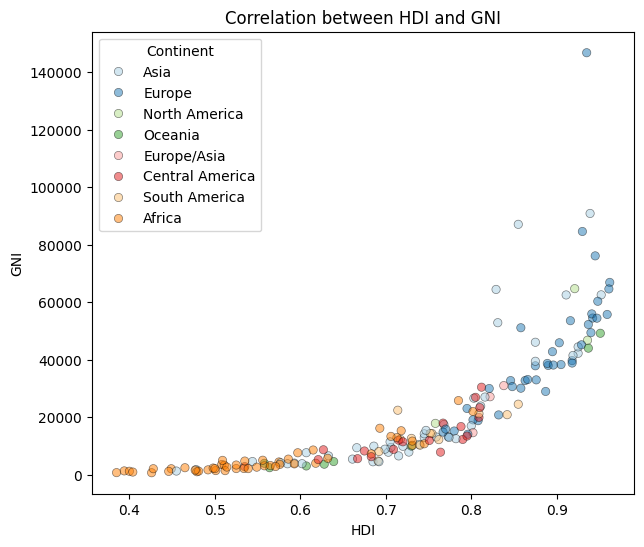

In [289]:
fig, ax = plt.subplots(figsize = (7,6))
sns.scatterplot(data=DF, y="GNI", x="HDI", **kwargs)  # TK
plt.title("Correlation between HDI and GNI")

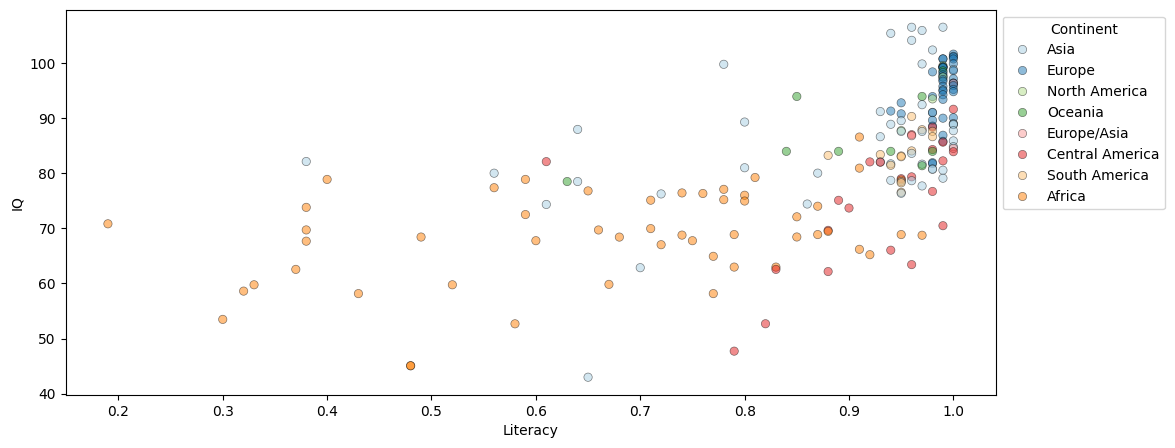

In [290]:
fig, ax = plt.subplots(figsize = (12,5))
sns.scatterplot(data=DF, y="IQ", x="Literacy", **kwargs)  # TK7
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


Text(0.5, 1.0, 'Distribution of IQ')

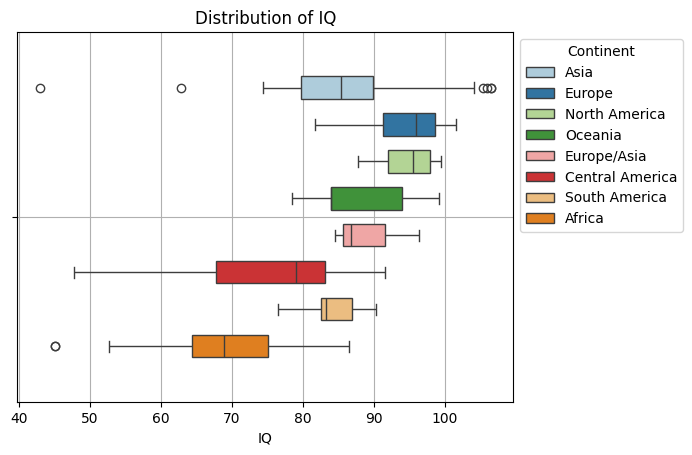

In [293]:
ax = sns.boxplot(data=DF, x="IQ",  gap=0.4, dodge=True, **{i:kwargs[i] for i in kwargs if i not in ['edgecolor', "alpha"]})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid()
plt.title("Distribution of IQ")


Text(0.5, 1.0, 'Correlation between years spent in school and literacy rate')

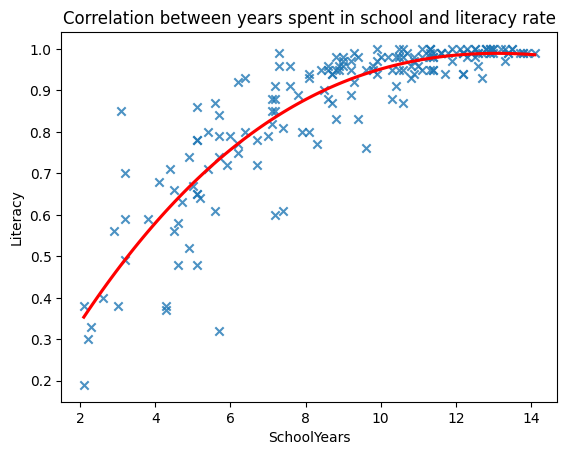

In [ ]:
sns.regplot(DF, x = "SchoolYears", y = "Literacy", order=3, ci=0, marker="x", line_kws=dict(color="r")) #TK: come up with own funciton???
plt.title("Correlation between years spent in school and literacy rate")


In [ ]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world

C:\Users\dima1\AppData\Local\Temp\ipykernel_33632\3969706699.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [ ]:
rank_location = DF[::]

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
rank_location['ISO_alpha'] = rank_location['Country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) else None)



C:\Users\dima1\AppData\Local\Temp\ipykernel_33632\3890966058.py:3: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [ ]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='SchoolYears',
    color_continuous_scale='YlOrRd',
    labels={'Rank': 'Rank'},
    title='Rank by Country',
    
    
    
)
fig.show()

In [ ]:
rank_location = DF

rank_location['ISO_alpha'] = rank_location['Country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) else None)

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

world = world.merge(rank_location, how='right', left_on='iso_a3', right_on='ISO_alpha')

fig = px.choropleth(
    world,
    locations='iso_a3',
    color='Nobels',
    color_continuous_scale='YlOrRd',
    labels={'Rank': 'Rank'},
    title='Rank by Country',
    
    
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)

fig.show()

C:\Users\dima1\AppData\Local\Temp\ipykernel_33632\3348294954.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



Text(0.5, 1.0, 'Most populated counties')

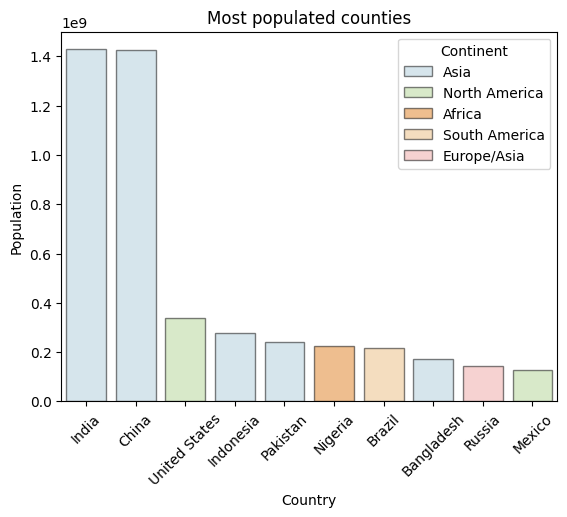

In [296]:
sns.barplot(DF.sort_values(by = "Population", ascending=False).head(10), x= "Country", y = "Population", **kwargs)
plt.xticks(rotation = 45)
plt.title("Most populated counties") #TK - not significant

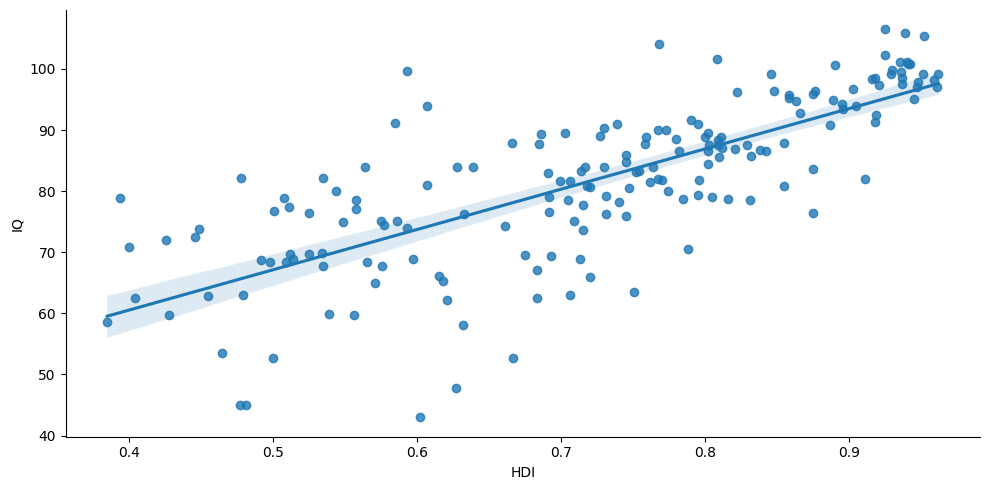

In [ ]:
sns.lmplot(DF, x = "HDI", y = "IQ", aspect=2)

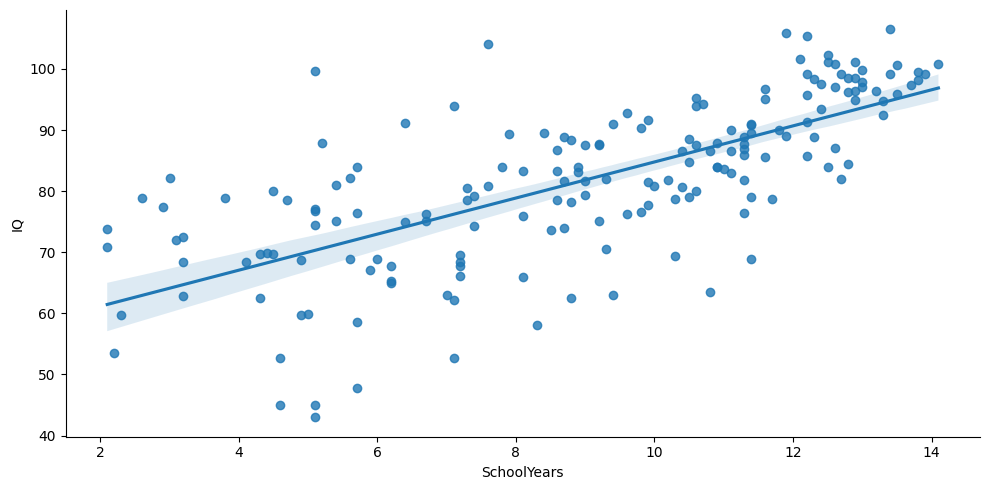

In [ ]:
sns.lmplot(DF, x = "SchoolYears", y = "IQ", aspect=2)


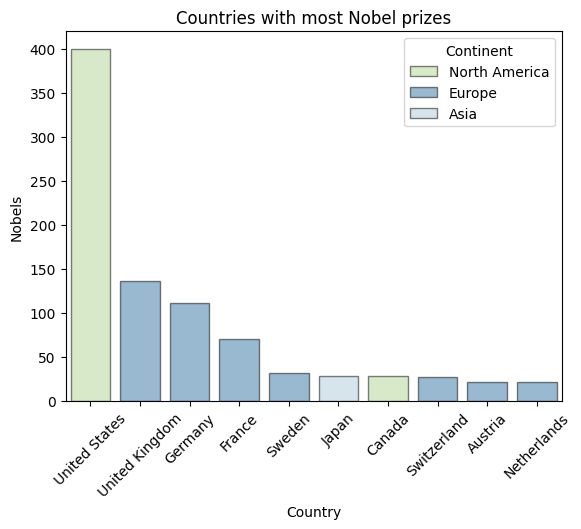

In [297]:
sns.barplot(DF.query("Nobels > 0").sort_values(by  = "Nobels", ascending=False).head(10), x = "Country", y = "Nobels",**kwargs)
plt.xticks(rotation = 45)
plt.title("Countries with most Nobel prizes")
plt.show()

In [ ]:
dfg = gp.GeoDataFrame(DF)


dfg["geometry"] = gp.tools.geocode(
    dfg["Country"], provider="nominatim", user_agent="add-your-app-name-here"
).geometry
dfg.crs = "EPSG:4326"
dfg.head()

# dfg = dfg.to_crs(epsg=3857)
# ax = dfg.plot(figsize=(16, 10), alpha=0.75, edgecolor='k', marker='o', color='red', markersize=dfg.Reach*5)
# ctx.add_basemap(ax)
# ax.set_axis_off()

C:\Users\dima1\AppData\Local\Temp\ipykernel_33632\2119421748.py:4: FutureWarning:

You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.



,Rank,Country,IQ,Continent,Literacy,Nobels,HDI,SchoolYears,GNI,Population,geometry
0,1,Japan,106.48,Asia,0.99,29,0.925,13.4,42274.0,1.232945e+08,POINT (139.23942 36.57484)
1,2,Taiwan,106.47,Asia,0.96,4,NaN,NaN,NaN,1.014354e+07,POINT (120.83538 23.59832)
2,3,Singapore,105.89,Asia,0.97,0,0.939,11.9,90919.0,6.014723e+06,POINT (103.81950 1.35711)
3,4,Hong Kong,105.37,Asia,0.94,1,0.952,12.2,62607.0,7.491609e+06,POINT (114.18492 22.35063)
4,5,China,104.10,Asia,0.96,8,0.768,7.6,17504.0,1.425671e+09,POINT (-94.33574 30.04799)


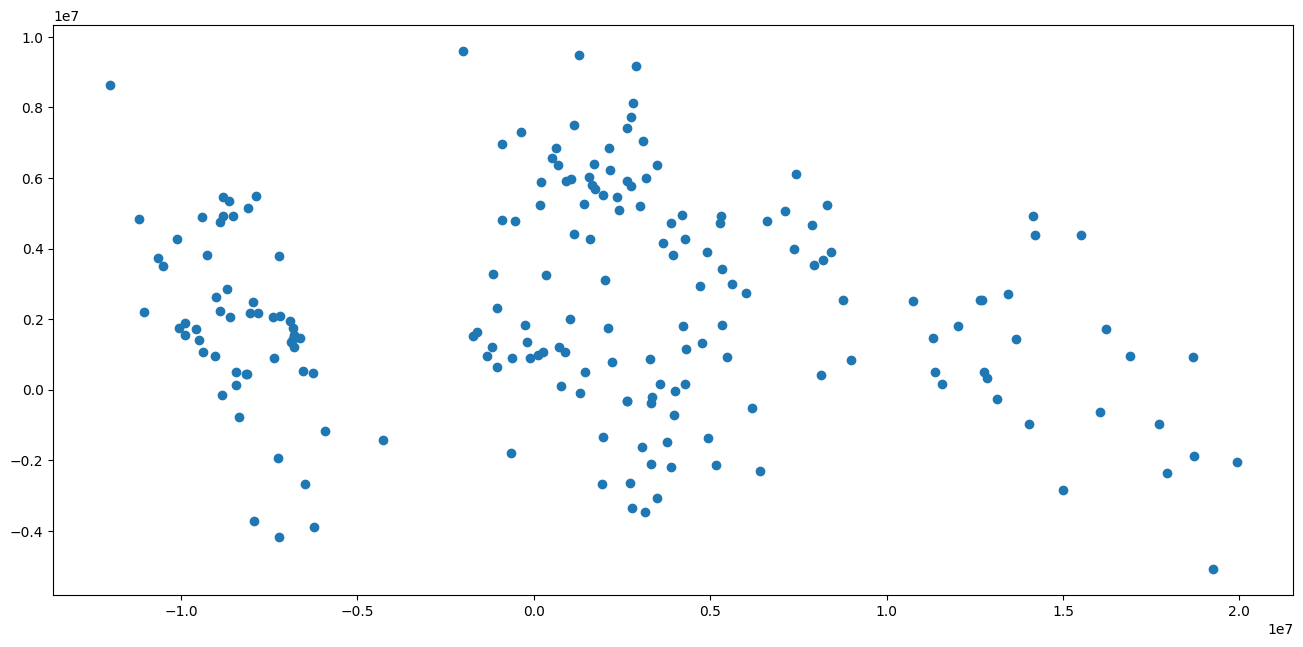

In [ ]:
dfg = dfg.to_crs(epsg=3857)
ax = dfg.plot(figsize=(16, 10))
# ctx.add_basemap(ax)
ax.set_axis_off()

<Axes: >

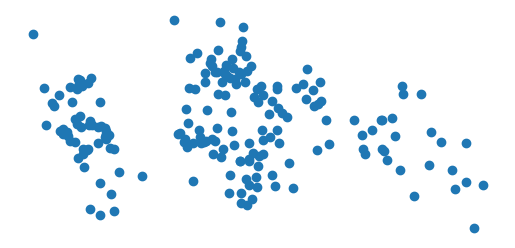

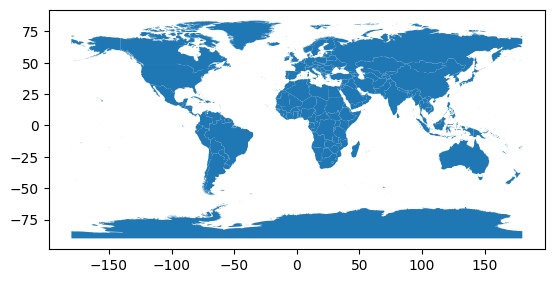

In [ ]:
MAP = gp.read_file("../Data/World_Countries/World_Countries.shp")
dfg = dfg.to_crs(epsg=3857)
ax = dfg.plot()  # figsize=(16, 10))
# ctx.add_basemap(ax)
ax.set_axis_off()

MAP.plot()

Text(0.5, 1.0, 'Kings County Price Heatmap')

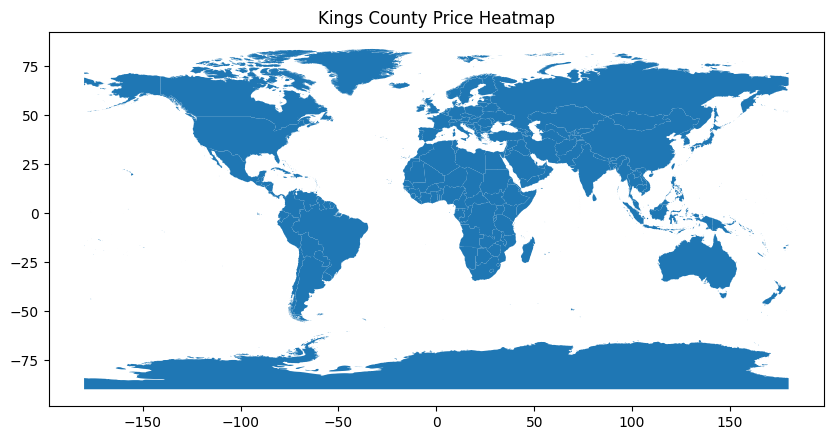

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# dfg.plot(column = 'Nobels', ax=ax,
#             legend = True, legend_kwds={'shrink': 0.3},
#             markersize = 15)

MAP.to_crs(epsg=4326).plot(ax=ax, figsize=(10, 10)).plot()
ax.set_title("Kings County Price Heatmap")

<Axes: >

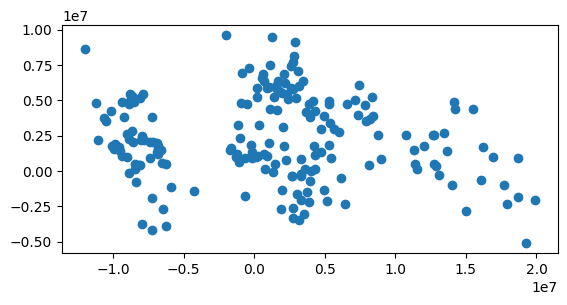

In [ ]:
dfg.plot()